In [714]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale
from sklearn.preprocessing import PolynomialFeatures as pf
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from scipy.cluster import hierarchy
from sklearn.model_selection import cross_val_predict
import sklearn.model_selection as ms

import statsmodels.api as sm

import traces

from pandas.plotting import register_matplotlib_converters

import re

%matplotlib inline
plt.style.use('seaborn-whitegrid')

## Preparing Training Data

In [715]:
bloombergNeg = pd.read_csv("data/labels/bloomberg_labels/bloomberg_neg_train.csv")
bloombergPos = pd.read_csv("data/labels/bloomberg_labels/bloomberg_pos_train.csv")
bloombergNeu = pd.read_csv("data/labels/bloomberg_labels/bloomberg_neu_train.csv")
bloombergTrain = pd.concat([bloombergNeg, bloombergPos, bloombergNeu], ignore_index=True)
bloombergTrain = bloombergTrain[['text', 's_label']]

In [716]:
bloombergTrain

,text,s_label
0,"Don't fret @CharmianNeary, Mike Bloomberg has been covering that 1% loss. @Gallagher4NY",-1
1,"https://t.co/XdH6DiqMJn - God help me, I’d vote for .@HillaryClinton b4 I’d vote for a nanny-state cunt like Mike Bloomberg.",-1
2,how is mike bloomberg not the same as goldman sachs?,-1
3,"Mike Bloomberg is 5'4"". WE AREN'T LIVING IN JAMES MADISON TIMES.",-1
4,Caller to @marklevinshow NAILED it. Trump is Mike Bloomberg. Out to get Cruz. Not Clinton.,-1
...,...,...
175,“There’s A Bully In The White!”\n-Mike Bloomberg,0
176,"If Mike Bloomberg’s $62.8 billion was put in a stack of $1 bills, it would reach *outer space* 63 times over.\n\n(For… https://t.co/cecBSadHf2",0
177,Hold on a second.. Mike Bloomberg is not my flavor.. Thanks to my maternal grandfather.. But! I love his style.. Su… https://t.co/z0IPX64J2D,0
178,@AprilDRyan @staceyabrams @TheView Mike Bloomberg is gonna cancel Stacey Ambrams’ check! https://t.co/7GYqnTPDHA,0


In [717]:
sandersNeg = pd.read_csv("data/labels/sanders_labels/sanders_neg_train.csv")
sandersPos = pd.read_csv("data/labels/sanders_labels/sanders_pos_train.csv")
sandersNeu = pd.read_csv("data/labels/sanders_labels/sanders_neu_train.csv")
sandersTrain = pd.concat([sandersNeg, sandersPos, sandersNeu], ignore_index=True)
sandersTrain = sandersTrain[['text', 's_label']]

In [718]:
buttigegNeg = pd.read_csv("data/labels/buttigieg_labels/buttigieg_neg_train.csv")
buttigegPos = pd.read_csv("data/labels/buttigieg_labels/buttigieg_pos_train.csv")
buttigegNeu = pd.read_csv("data/labels/buttigieg_labels/buttigieg_neu_train.csv")
buttigiegTrain = pd.concat([buttigegNeg, buttigegPos, buttigegNeu], ignore_index=True)
buttigiegTrain = buttigiegTrain[['text', 's_label']]

In [719]:
bidenNeg = pd.read_csv("data/labels/biden_labels/biden_neg_train.csv")
bidenPos = pd.read_csv("data/labels/biden_labels/biden_pos_train.csv")
bidenNeu = pd.read_csv("data/labels/biden_labels/biden_neu_train.csv")
bidenTrain = pd.concat([bidenNeg, bidenPos, bidenNeu], ignore_index=True)
bidenTrain = bidenTrain[['text', 's_label']]

In [720]:
warrenNeg = pd.read_csv("data/labels/warren_labels/warren_neg_train.csv")
warrenPos = pd.read_csv("data/labels/warren_labels/warren_pos_train.csv")
warrenNeu = pd.read_csv("data/labels/warren_labels/warren_neu_train.csv")
warrenTrain = pd.concat([warrenNeg, warrenPos, warrenNeu], ignore_index=True)
warrenTrain = warrenTrain[['text', 's_label']]

In [721]:
klobucharNeg = pd.read_csv("data/labels/klobuchar_labels/klobuchar_neg_train.csv")
klobucharPos = pd.read_csv("data/labels/klobuchar_labels/klobuchar_pos_train.csv")
klobucharNeu = pd.read_csv("data/labels/klobuchar_labels/klobuchar_neu_train.csv")
klobucharTrain = pd.concat([klobucharNeg, klobucharPos, klobucharNeu], ignore_index=True)
klobucharTrain = klobucharTrain[['text', 's_label']]

In [722]:
def delta(series):
    changes = list()
    for i in range(1,series.size):
        changes.append(series[i] - series[i-1])
    changes = pd.Series(changes)
    changes = changes.fillna(0)
    return changes

In [723]:
def buildTuples(df):
    tups = list()
    for index, row in df.iterrows():
        tups.append((row['ts'], row['sentiment']))
    return tups

## Buttigieg

In [724]:
buttigiegFull = pd.read_csv("data/tweets_full/buttigieg_full.csv")

In [725]:
def  clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    return df

In [726]:
bloombergTrain = clean_text(bloombergTrain, "text")
buttigiegTrain = clean_text(buttigiegTrain, "text")
sandersTrain = clean_text(sandersTrain, "text")
bidenTrain = clean_text(bidenTrain, "text")
warrenTrain = clean_text(warrenTrain, "text")
klobucharTrain = clean_text(klobucharTrain, "text")

In [727]:
words = set()
for tweet in sandersTrain.text:
    splitWords = tweet.split(" ")
    for sw in splitWords:
        words.add(sw)
print(len(words))

902


In [730]:
pipeline_sgd = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf',  TfidfTransformer()),
    ("lr", LogisticRegression(max_iter=1000))
#     ('sgd', SGDClassifier(loss="log", penalty=None)),
#     ("rf", RandomForestClassifier(max_depth=10000, random_state=55))
])

In [731]:
X_train, X_test, y_train, y_test = train_test_split(sandersTrain['text'],
                                                    sandersTrain['s_label'],random_state = 0)
model = pipeline_sgd.fit(X_train, y_train)
y_predict = model.predict(X_test)
f1_score(y_test, y_predict, average="macro")

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.5081349206349206

In [357]:
model = pipeline_sgd.fit(bidenTrain['text'], bidenTrain['s_label'])
y_predict = model.predict(bidenFull['text'])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [358]:
bidenFreq = dict()
for i in y_predict:
    i = i.item()
    if i not in bidenFreq:
        bidenFreq[i] = 1
    else:
        bidenFreq[i] += 1

In [359]:
bidenFreq

{-1: 23518, 0: 12442, 1: 13847}

In [360]:
type(y_predict)

numpy.ndarray

In [361]:
buttigiegSentiment = pd.Series(y_predict)

In [362]:
buttigiegSentiment

0       -1
1        0
2        0
3        0
4        1
        ..
49802    1
49803    1
49804    1
49805   -1
49806   -1
Length: 49807, dtype: int64

In [363]:
buttigiegFull['sentiment'] = buttigiegSentiment

In [364]:
buttigiegFull

,tweetid,date,text,favorites,retweets,location,sentiment
0,1144416035375898627,2019-06-28,Pete Buttigieg is James Madison reincarnated,0.0,0.0,United States,-1
1,810262559613919232,2016-12-17,"More Democrats like this, please: ""A letter from flyover country” by Pete Buttigieg https://t.co/aptsdItXZH",0.0,0.0,United States,0
2,817842044785790981,2017-01-07,#Bernie fan 16 yrs before it was cool. \nProgressive South Bend Mayor Pete Buttigieg \nHuffPost re @PeteforDNC \nhttps://t.co/O2AyNsHCAv,0.0,0.0,United States,0
3,822225176339382273,2017-01-19,@AbiWilks I like him but I'm pulling for longshot outsider Pete Buttigieg.,0.0,0.0,United States,0
4,826811241775689728,2017-02-01,I have such a crush on Pete Buttigieg.,0.0,0.0,United States,1
...,...,...,...,...,...,...,...
6156,1235647846378098688,2020-03-05,"@DavidCornDC @ewarren Well she wasn't the smartest, Pete Buttigieg is a genius, but she is fantastic with lots of g… https://t.co/EZorEy8TvC",0.0,0.0,United States,1
6157,1235798531350257670,2020-03-06,1. Elizabeth Warren\n2. Julian Castro\n3. Bernie Sanders\n4. Andrew Yang\n5. Pete Buttigieg\n\nThis was my list from the… https://t.co/UavOLtqGBq,0.0,0.0,United States,-1
6158,1236495161548570624,2020-03-08,Pete Buttigieg_Thank-You to Supporters https://t.co/EytVufM6sf #audio via @chirbit,0.0,0.0,United States,-1
6159,1236520096136396803,2020-03-08,Pete Buttigieg Birthday Party in the Cedar Rapids office. https://t.co/YA0QGWbqnV,0.0,0.0,United States,-1


In [365]:
pd.to_datetime(buttigiegFull.date[0])

Timestamp('2019-06-28 00:00:00')

In [366]:
ts = list()
for index, row in buttigiegFull.iterrows():
    ts.append(pd.to_datetime(row['date']))

In [367]:
buttigiegFull['ts'] = pd.Series(ts)

In [368]:
buttigiegFull

,tweetid,date,text,favorites,retweets,location,sentiment,ts
0,1144416035375898627,2019-06-28,Pete Buttigieg is James Madison reincarnated,0.0,0.0,United States,-1,2019-06-28
1,810262559613919232,2016-12-17,"More Democrats like this, please: ""A letter from flyover country” by Pete Buttigieg https://t.co/aptsdItXZH",0.0,0.0,United States,0,2016-12-17
2,817842044785790981,2017-01-07,#Bernie fan 16 yrs before it was cool. \nProgressive South Bend Mayor Pete Buttigieg \nHuffPost re @PeteforDNC \nhttps://t.co/O2AyNsHCAv,0.0,0.0,United States,0,2017-01-07
3,822225176339382273,2017-01-19,@AbiWilks I like him but I'm pulling for longshot outsider Pete Buttigieg.,0.0,0.0,United States,0,2017-01-19
4,826811241775689728,2017-02-01,I have such a crush on Pete Buttigieg.,0.0,0.0,United States,1,2017-02-01
...,...,...,...,...,...,...,...,...
6156,1235647846378098688,2020-03-05,"@DavidCornDC @ewarren Well she wasn't the smartest, Pete Buttigieg is a genius, but she is fantastic with lots of g… https://t.co/EZorEy8TvC",0.0,0.0,United States,1,2020-03-05
6157,1235798531350257670,2020-03-06,1. Elizabeth Warren\n2. Julian Castro\n3. Bernie Sanders\n4. Andrew Yang\n5. Pete Buttigieg\n\nThis was my list from the… https://t.co/UavOLtqGBq,0.0,0.0,United States,-1,2020-03-06
6158,1236495161548570624,2020-03-08,Pete Buttigieg_Thank-You to Supporters https://t.co/EytVufM6sf #audio via @chirbit,0.0,0.0,United States,-1,2020-03-08
6159,1236520096136396803,2020-03-08,Pete Buttigieg Birthday Party in the Cedar Rapids office. https://t.co/YA0QGWbqnV,0.0,0.0,United States,-1,2020-03-08


In [369]:
buttigiegFull['test']= pd.to_datetime(buttigiegFull['ts']) - pd.to_timedelta(7, unit='d')

In [370]:
b = buttigiegFull.groupby([pd.Grouper(key='test', freq='W-MON')])['sentiment'].mean().reset_index().sort_values('test')

In [371]:
b

,test,sentiment
0,2016-05-02,-1.000000
1,2016-05-09,NaN
2,2016-05-16,NaN
3,2016-05-23,NaN
4,2016-05-30,1.000000
...,...,...
196,2020-02-03,-0.191972
197,2020-02-10,-0.276978
198,2020-02-17,-0.107744
199,2020-02-24,-0.284501


In [372]:
b.to_csv("b.csv")

In [373]:
b = b.fillna(method="ffill")

In [374]:
b.to_csv("b.csv")

Text(0.5, 0, 'Date')

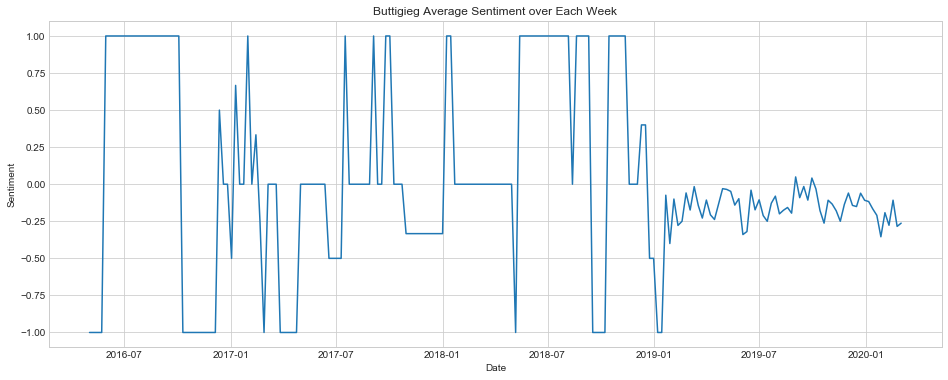

In [375]:
plt.figure(figsize=(16, 6))
ax = sns.lineplot(x=b["test"], y=b["sentiment"], data=b)
plt.title("Buttigieg Average Sentiment over Each Week")
ax.set_ylabel("Sentiment")
ax.set_xlabel("Date")

## Sanders

In [376]:
sandersFull = pd.read_csv("data/tweets_full/sanders_full.csv", index_col = None, header=0, engine='python')

In [377]:
sandersFull

,tweetid,date,text,favorites,retweets,location
0,677808959424622592,2015-12-18,Bernie Sanders campaign accessed Hillary Clinton’s confidential voter information https://t.co/NTee8ghs1N…@HillaryClinton @SenWarren,0.0,0.0,United States
1,677842280498073600,2015-12-18,Bernie Sanders wins the day https://t.co/a3wLxr65HL #copolitics #coleg #Colorado #Denver #Boulder,0.0,0.0,United States
2,677871498841862144,2015-12-18,Related: @moveon PETITION to Debbie Wasserman Schultz: Give voter file back to #Bernie Sanders' campaign https://t.co/1ywPE92L1R cc @drshow,0.0,0.0,United States
3,677877872598454273,2015-12-18,Bernie Sanders Staffer playing dirty against Hillary Clinton #BernieSanders\n#djB_MonEy,0.0,0.0,United States
4,677880021436858368,2015-12-18,Debbie Wasserman Schultz: Give the voter file back to Bernie Sanders' campaign https://t.co/KuRMSmsM7G @moveon This is important.,0.0,0.0,United States
...,...,...,...,...,...,...
97449,1236804133539078144,2020-03-09,“We need mini golf reform and Bernie Sanders is the man to do it” -@tvanauk10,0.0,0.0,United States
97450,1236814443058794498,2020-03-09,'I think we've got a great shot to win in Michigan ... Washington': Bernie Sanders https://t.co/ZMwqfyiFsE,0.0,0.0,United States
97451,1236828913881366528,2020-03-09,Bernie Sanders is 100 percent a legitimate Working Class Hero,0.0,0.0,United States
97452,1236840116179648517,2020-03-09,"No one cares about Bernie sanders except us, the working class of America. #NotMeUs we have to stop the billionair… https://t.co/PUhWmcOzXt",0.0,0.0,United States


In [378]:
model = pipeline_sgd.fit(sandersTrain['text'], sandersTrain['s_label'])
sanders_predict = model.predict(sandersFull['text'])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [379]:
freq = dict()
for i in sanders_predict:
    i = i.item()
    if i not in freq:
        freq[i] = 1
    else:
        freq[i] += 1
freq
sandersFull['sentiment'] = sanders_predict

In [380]:
pd.set_option('display.max_colwidth', -1)
sandersFull[['text', 'sentiment']][0:10]

,text,sentiment
0,Bernie Sanders campaign accessed Hillary Clinton’s confidential voter information https://t.co/NTee8ghs1N…@HillaryClinton @SenWarren,-1
1,Bernie Sanders wins the day https://t.co/a3wLxr65HL #copolitics #coleg #Colorado #Denver #Boulder,1
2,Related: @moveon PETITION to Debbie Wasserman Schultz: Give voter file back to #Bernie Sanders' campaign https://t.co/1ywPE92L1R cc @drshow,0
3,Bernie Sanders Staffer playing dirty against Hillary Clinton #BernieSanders\n#djB_MonEy,-1
4,Debbie Wasserman Schultz: Give the voter file back to Bernie Sanders' campaign https://t.co/KuRMSmsM7G @moveon This is important.,0
5,Bernie Sanders will not get us free college. Im sorry. This has to stop being propogated in the social media liberal community.,-1
6,What else did Bernie Sanders STEAL! In today society people can steal your entire life with just your address. Plus they have our full name?,-1
7,Debbie Wasserman Schultz: Give the voter file back to Bernie Sanders' campaign https://t.co/hf65S6fMhD @MoveOn @TheDemocrats @BernieSanders,0
8,"Sorry, this Bernie Sanders data breach has a funny smell to it. #ThingsThatMakeYouGoHmmm",-1
9,Bernie Sanders Campaign Locked Out Of Key Voter File After Data Breach https://t.co/LttN6ZaT9S,0


In [381]:
ts = list()
for index, row in sandersFull.iterrows():
    try:
        ts.append(pd.to_datetime(row['date']))
    except:
        ts.append(0)

In [386]:
bad = 0
for i in range(0,len(ts)):
    if ts[i] == 0:
        ts[i] = ts[i-1]
bad
sandersFull['ts'] = pd.Series(ts)

In [387]:
sandersFull['test']= pd.to_datetime(sandersFull['ts']) - pd.to_timedelta(7, unit='d')

In [388]:
sandersFull['test']= pd.to_datetime(sandersFull['ts']) - pd.to_timedelta(7, unit='d')
s = sandersFull.groupby([pd.Grouper(key='test', freq='W-MON')])['sentiment'].mean().reset_index().sort_values('test')

In [389]:
s

,test,sentiment
0,2015-11-16,0.833333
1,2015-11-23,0.174877
2,2015-11-30,0.145985
3,2015-12-07,0.237261
4,2015-12-14,0.084261
...,...,...
220,2020-02-03,0.069182
221,2020-02-10,0.057674
222,2020-02-17,0.057985
223,2020-02-24,0.003365


Text(0.5, 0, 'Date')

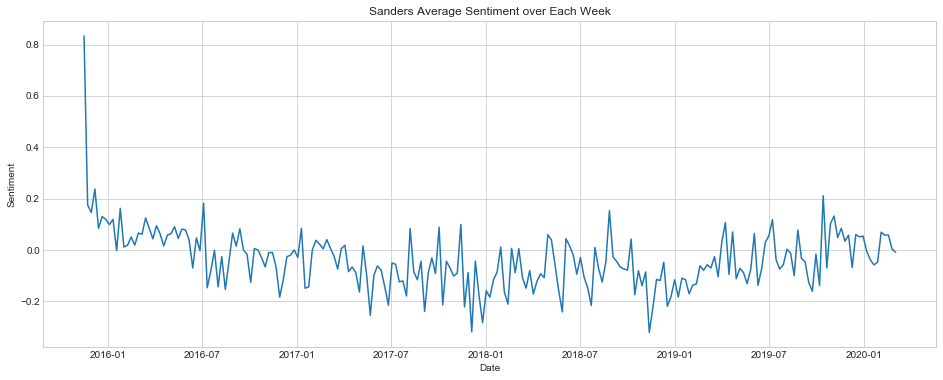

In [390]:
plt.figure(figsize=(16, 6))
ax = sns.lineplot(x=s["test"], y=s["sentiment"], data=b)
plt.title("Sanders Average Sentiment over Each Week")
ax.set_ylabel("Sentiment")
ax.set_xlabel("Date")

## Bloomberg

In [393]:
bloombergFull = pd.read_csv("data/tweets_full/bloomberg_full.csv")

In [394]:
bloombergFull

,tweetid,date,text,favorites,retweets,location,s_label
0,685222562431766528,2016-01-07,#tbt That time when Cass and I played at a Mike Bloomberg campaign event. #NYC #bloomberg… https://t.co/unNlbOM1pe,0.0,0.0,United States,0
1,687151925574381568,2016-01-13,"Don't fret @CharmianNeary, Mike Bloomberg has been covering that 1% loss. @Gallagher4NY",0.0,0.0,United States,-1
2,690918632390574080,2016-01-23,Mike Bloomberg Candidacy is a vote I can cast without any hesitation.,0.0,0.0,United States,1
3,691385675913007109,2016-01-24,"https://t.co/XdH6DiqMJn - God help me, I’d vote for .@HillaryClinton b4 I’d vote for a nanny-state cunt like Mike Bloomberg.",0.0,0.0,United States,-1
4,691993828274892800,2016-01-26,I hope Mike Bloomberg runs for president as an independent #saveamerica,0.0,0.0,United States,1
...,...,...,...,...,...,...,...
3870,1235754134483152898,2020-03-06,Dump Trump | Mike Bloomberg for President https://t.co/ztDzBVA9ir via @YouTube,0.0,0.0,United States,0
3871,1235976072350625792,2020-03-06,Do you know how stupid that sounds to most Americans. Mike Bloomberg has a lot money but not enough to give all Ame… https://t.co/QTppkWGYHN,0.0,0.0,United States,0
3872,1236127585941237762,2020-03-07,@JoeBiden @MikeBloomberg President Joe Biden and VP Mike Bloomberg would be the winning ticket,0.0,0.0,United States,0
3873,1236151431825985537,2020-03-07,"纽约的两名確診新冠狀病毒患者参加了AIPAC，其他参会者包括Mike Pompeo, Mitch McConnell, Ted Cruz, Liz Cheney, Mike Bloomberg, Cory Booker，還有副總統… https://t.co/o9jIqIYItR",0.0,0.0,United States,0


In [395]:
model = pipeline_sgd.fit(bloombergTrain['text'], bloombergTrain['s_label'])
bloomberg_predict = model.predict(bloombergFull['text'])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [396]:
bloombergFull['sentiment'] = pd.Series(bloomberg_predict)

In [397]:
ts = list()
for index, row in bloombergFull.iterrows():
    try:
        ts.append(pd.to_datetime(row['date']))
    except:
        ts.append(0)
bad = 0
for i in range(0,len(ts)):
    if ts[i] == 0:
        ts[i] = ts[i-1]
bloombergFull['ts'] = pd.Series(ts)

In [398]:
bloombergFull['test']= pd.to_datetime(bloombergFull['ts']) - pd.to_timedelta(7, unit='d')
bloom = bloombergFull.groupby([pd.Grouper(key='test', freq='W-MON')])['sentiment'].mean().reset_index().sort_values('test')

In [399]:
bloom

,test,sentiment
0,2015-11-23,0.000000
1,2015-11-30,0.250000
2,2015-12-07,-0.333333
3,2015-12-14,-1.000000
4,2015-12-21,0.333333
...,...,...
219,2020-02-03,0.073930
220,2020-02-10,-0.011450
221,2020-02-17,-0.012458
222,2020-02-24,-0.063877


Text(0.5, 0, 'Date')

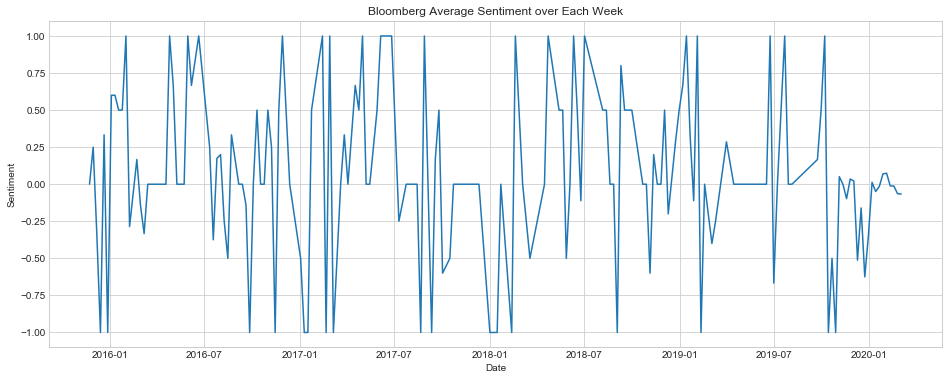

In [400]:
plt.figure(figsize=(16, 6))
ax = sns.lineplot(x=bloom["test"], y=bloom["sentiment"], data=b)
plt.title("Bloomberg Average Sentiment over Each Week")
ax.set_ylabel("Sentiment")
ax.set_xlabel("Date")

## Biden

In [401]:
bidenFull = pd.read_csv("data/tweets_full/biden_full.csv")
model = pipeline_sgd.fit(bidenTrain['text'], bidenTrain['s_label'])
biden_predict = model.predict(bidenFull['text'])
bidenFull['sentiment'] = pd.Series(biden_predict)
ts = list()
for index, row in bidenFull.iterrows():
    try:
        ts.append(pd.to_datetime(row['date']))
    except:
        ts.append(0)
bad = 0
for i in range(0,len(ts)):
    if ts[i] == 0:
        ts[i] = ts[i-1]
bidenFull['ts'] = pd.Series(ts)
bidenFull['test']= pd.to_datetime(bidenFull['ts']) - pd.to_timedelta(7, unit='d')
bid = bidenFull.groupby([pd.Grouper(key='test', freq='W-MON')])['sentiment'].mean().reset_index().sort_values('test')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Text(0.5, 0, 'Date')

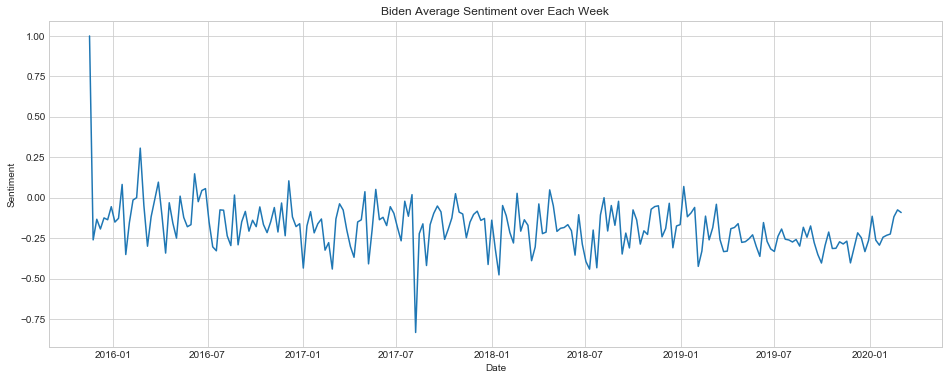

In [402]:
plt.figure(figsize=(16, 6))
ax = sns.lineplot(x=bid['test'], y=bid['sentiment'])
plt.title("Biden Average Sentiment over Each Week")
ax.set_ylabel("Sentiment")
ax.set_xlabel("Date")

## Warren

In [403]:
warrenFull = pd.read_csv("data/tweets_full/warren_full.csv")
warrenFull['text'] = warrenFull.text.fillna('')
warrenFull

,tweetid,date,text,favorites,retweets,location
0,683414547005337601,2016-01-02,Elizabeth Warren SLAMS Hillary Clinton With Most Damaging Evidence To Date https://t.co/i91CF6CIbb via YouTube,0.0,0.0,United States
1,684962737483595776,2016-01-07,"I appreciate the work Hilary Clinton has done, but I don't think she should be the first woman president. Senator Elizabeth Warren should",0.0,0.0,United States
2,685323287195430912,2016-01-08,Elizabeth Warren: Wake up Liz! We need you to endorse Bernie now! https://t.co/bMFW5ACuF9 via @Change #FeelTheBern https://t.co/CGu2ZR5JpC,0.0,0.0,United States
3,685507145119449088,2016-01-08,"@BernieSanders Sir, if we pick Elizabeth Warren for VP. before the Iowa Caucus would that help us with the women's vote?",0.0,0.0,United States
4,685658618813935616,2016-01-09,It's a rare man who can steer Elizabeth Warren and Rand Paul to consensus: https://t.co/SP8tj4wfw8 https://t.co/QZNfnTzbQt,0.0,0.0,United States
...,...,...,...,...,...,...
35501,1236823533457534979,2020-03-09,I love Elizabeth Warren 😂,0.0,0.0,United States
35502,1236842814735929344,2020-03-09,Sen. Elizabeth Warren leaving the race made things crystal clear for me - I'm voting for Sen. Bernie Sanders on Tuesday.,0.0,0.0,United States
35503,1236846142098419713,2020-03-09,@danielmarans @JinokAnderson Is Elizabeth Warren’s showdown with Biden over the 2005 bankruptcy bill really “epic”… https://t.co/3jj2sSA5d7,0.0,0.0,United States
35504,1236865594986815489,2020-03-09,"“My name is Elizabeth and I'm running for president, because that's what girls do."" -Elizabeth Warren. I will never… https://t.co/coNxA1lhhu",0.0,0.0,United States


In [404]:
model = pipeline_sgd.fit(warrenTrain['text'], warrenTrain['s_label'])
warren_predict = model.predict(warrenFull['text'])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [405]:
warrenFull = pd.read_csv("data/tweets_full/warren_full.csv")
warrenFull['text'] = warrenFull.text.fillna('')
model = pipeline_sgd.fit(warrenTrain['text'], warrenTrain['s_label'])
warren_predict = model.predict(warrenFull['text'])
warrenFull['sentiment'] = pd.Series(warren_predict)
ts = list()
for index, row in warrenFull.iterrows():
    try:
        ts.append(pd.to_datetime(row['date']))
    except:
        ts.append(0)
bad = 0
for i in range(0,len(ts)):
    if ts[i] == 0:
        ts[i] = ts[i-1]
warrenFull['ts'] = pd.Series(ts)
warrenFull['test']= pd.to_datetime(warrenFull['ts']) - pd.to_timedelta(7, unit='d')
war = warrenFull.groupby([pd.Grouper(key='test', freq='W-MON')])['sentiment'].mean().reset_index().sort_values('test')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [406]:
war

,test,sentiment
0,2015-11-16,0.000000
1,2015-11-23,0.200000
2,2015-11-30,-0.074074
3,2015-12-07,0.375000
4,2015-12-14,0.111111
...,...,...
220,2020-02-03,0.000000
221,2020-02-10,0.052009
222,2020-02-17,0.148101
223,2020-02-24,0.125786


Text(0.5, 0, 'Date')

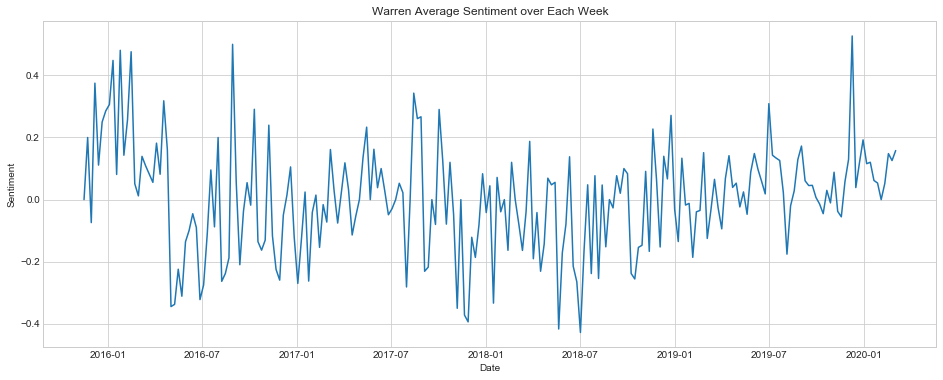

In [407]:
plt.figure(figsize=(16, 6))
ax = sns.lineplot(x=war["test"], y=war["sentiment"], data=b)
plt.title("Warren Average Sentiment over Each Week")
ax.set_ylabel("Sentiment")
ax.set_xlabel("Date")

## Klobuchar

In [408]:
klobucharFull = pd.read_csv("data/tweets_full/klobuchar_full.csv")
klobucharFull['text'] = klobucharFull.text.fillna('')
model = pipeline_sgd.fit(klobucharTrain['text'], klobucharTrain['s_label'])
klobuchar_predict = model.predict(klobucharFull['text'])
klobucharFull['sentiment'] = pd.Series(klobuchar_predict)
ts = list()
for index, row in klobucharFull.iterrows():
    try:
        ts.append(pd.to_datetime(row['date']))
    except:
        ts.append(0)
bad = 0
for i in range(0,len(ts)):
    if ts[i] == 0:
        ts[i] = ts[i-1]
klobucharFull['ts'] = pd.Series(ts)
klobucharFull['test']= pd.to_datetime(klobucharFull['ts']) - pd.to_timedelta(7, unit='d')
klob = klobucharFull.groupby([pd.Grouper(key='test', freq='W-MON')])['sentiment'].mean().reset_index().sort_values('test')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [409]:
klob

,test,sentiment
0,2015-11-23,0.000000
1,2015-11-30,1.000000
2,2015-12-07,1.000000
3,2015-12-14,1.000000
4,2015-12-21,NaN
...,...,...
219,2020-02-03,-0.106481
220,2020-02-10,-0.109453
221,2020-02-17,-0.110672
222,2020-02-24,-0.228013


Text(0.5, 0, 'Date')

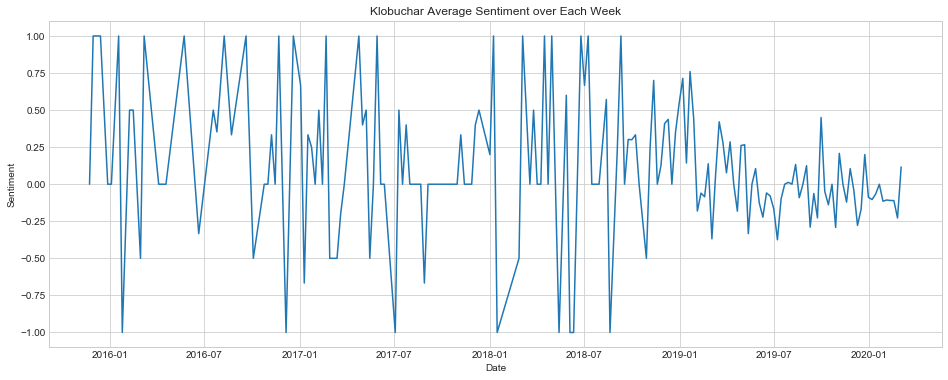

In [410]:
plt.figure(figsize=(16, 6))
ax = sns.lineplot(x=klob["test"], y=klob["sentiment"])
plt.title("Klobuchar Average Sentiment over Each Week")
ax.set_ylabel("Sentiment")
ax.set_xlabel("Date")

## Changes

In [549]:
klobChange = delta(klob['sentiment'])

In [550]:
warrenChange = delta(war['sentiment'])

In [551]:
bidenChange = delta(bid['sentiment'])

In [552]:
bloombergChange = delta(bloom['sentiment'])

In [553]:
buttigiegChange = delta(b['sentiment'])

In [554]:
sandersChange = delta(s['sentiment'])

In [555]:
klobDF = pd.DataFrame(klobChange)
warrenDF = pd.DataFrame(warrenChange)
bidenDF = pd.DataFrame(bidenChange)
bloombergDF = pd.DataFrame(bloombergChange)
buttigiegDF = pd.DataFrame(buttigiegChange)
sandersDF = pd.DataFrame(sandersChange)

In [556]:
klobDF.loc[-1] = [np.nan]  # adding a row
klobDF.index = klobDF.index + 1  # shifting index
klobDF = klobDF.sort_index()  # sorting by index
klobDF['time'] = klob['test']
klobDF.columns = ['change', 'time']

In [557]:
warrenDF.loc[-1] = [np.nan]  # adding a row
warrenDF.index = warrenDF.index + 1  # shifting index
warrenDF = warrenDF.sort_index()  # sorting by index
warrenDF['time'] = war['test']
warrenDF.columns = ['change', 'time']

In [558]:
bidenDF.loc[-1] = [np.nan]  # adding a row
bidenDF.index = bidenDF.index + 1  # shifting index
bidenDF = bidenDF.sort_index()  # sorting by index
bidenDF['time'] = bid['test']
bidenDF.columns = ['change', 'time']

In [559]:
bloombergDF.loc[-1] = [np.nan]  # adding a row
bloombergDF.index = bloombergDF.index + 1  # shifting index
bloombergDF = bloombergDF.sort_index()  # sorting by index
bloombergDF['time'] = bloom['test']
bloombergDF.columns = ['change', 'time']

In [560]:
buttigiegDF.loc[-1] = [np.nan]  # adding a row
buttigiegDF.index = buttigiegDF.index + 1  # shifting index
buttigiegDF = buttigiegDF.sort_index()  # sorting by index
buttigiegDF['time'] = b['test']
buttigiegDF.columns = ['change', 'time']

In [561]:
sandersDF.loc[-1] = [np.nan]  # adding a row
sandersDF.index = sandersDF.index + 1  # shifting index
sandersDF = sandersDF.sort_index()  # sorting by index
sandersDF['time'] = s['test']
sandersDF.columns = ['change', 'time']

Text(0.5, 0, 'Date')

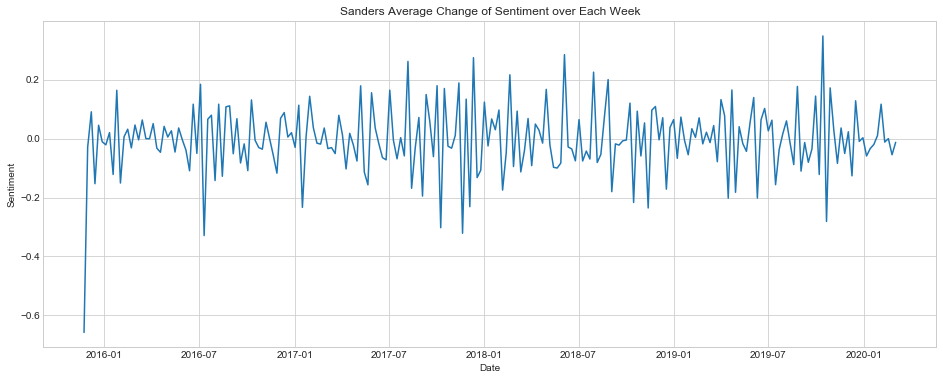

In [425]:
plt.figure(figsize=(16, 6))
ax = sns.lineplot(x=sandersDF["time"], y=sandersDF["change"], data=sandersDF)
plt.title("Sanders Average Change of Sentiment over Each Week")
ax.set_ylabel("Sentiment")
ax.set_xlabel("Date")

## Correlations
### Sanders

In [563]:
sandersPollChanges = pd.read_csv("sandersChangeDF.csv")

In [564]:
sandersDF
sandersDF['year'] = pd.DatetimeIndex(sandersDF['time']).year
sandersDF['month'] = pd.DatetimeIndex(sandersDF['time']).month
sandersDF['day'] = pd.DatetimeIndex(sandersDF['time']).day

In [565]:
sandersPollChanges.columns = ['time', 'change']

In [521]:
sandersPollChanges['year'] = pd.DatetimeIndex(sandersPollChanges['time']).year
sandersPollChanges['month'] = pd.DatetimeIndex(sandersPollChanges['time']).month
sandersPollChanges['day'] = pd.DatetimeIndex(sandersPollChanges['time']).day

In [566]:
sandersPollChanges['test']= pd.to_datetime(sandersPollChanges['time']) - pd.to_timedelta(7, unit='d')
sandersPollChangesGrouped = sandersPollChanges.groupby([pd.Grouper(key='test', freq='W-MON')])['change'].mean().reset_index().sort_values('test')

In [569]:
sandersDFScoped = sandersDF[sandersDF['time'] >= sandersPollChanges['time'][0]]

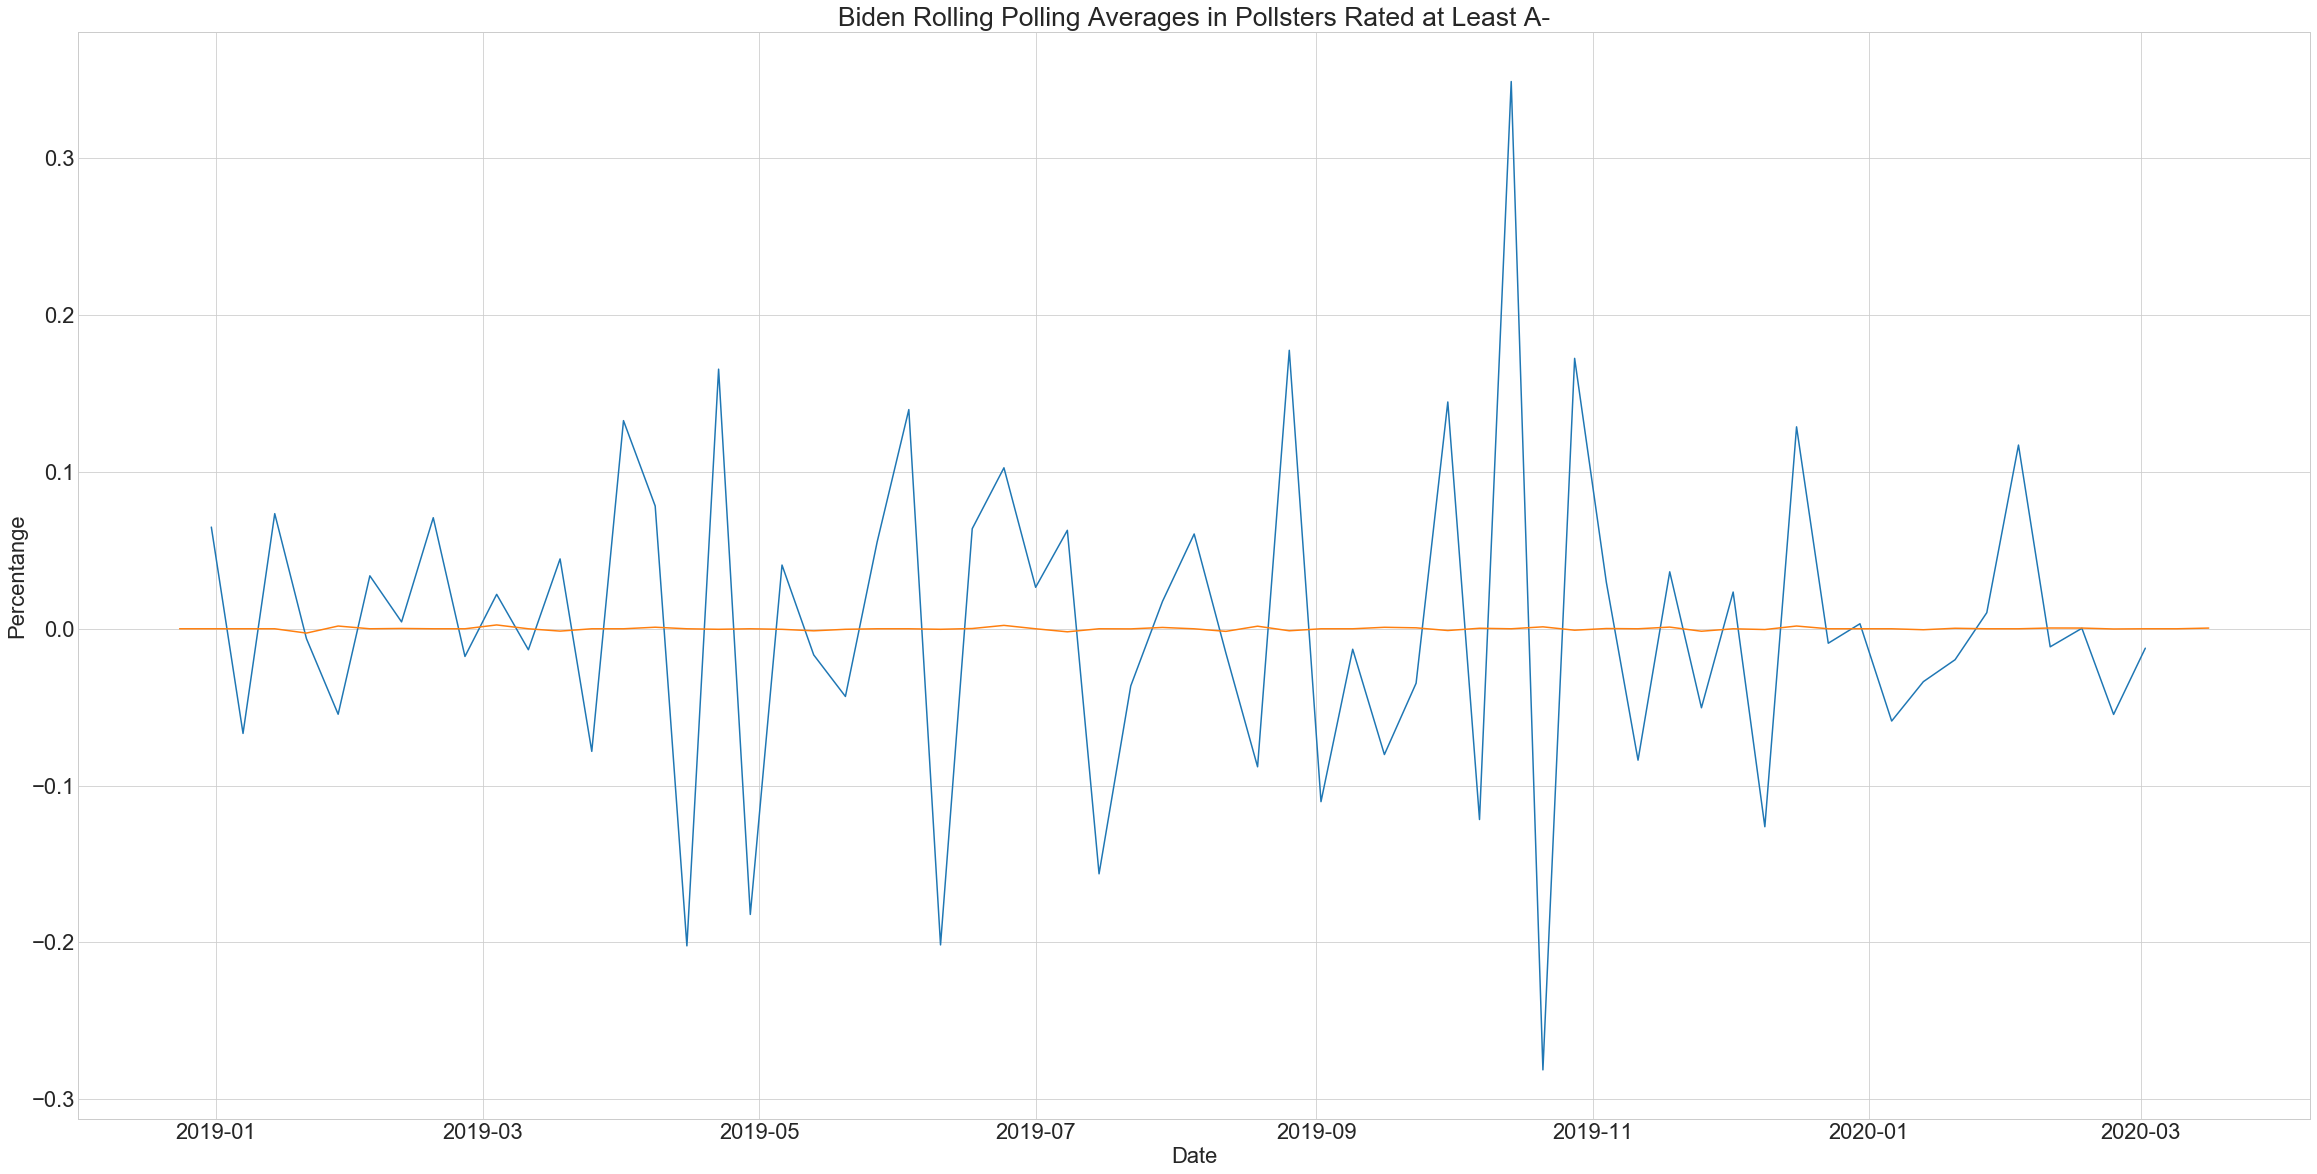

In [570]:
fig = plt.figure()
#plt.rcParams.update({'font.size': 26})
plt.plot(sandersDFScoped['time'], sandersDFScoped['change'])
plt.plot(sandersPollChangesGrouped['test'], sandersPollChangesGrouped['change'])
plt.rcParams['figure.figsize'] = [40, 20]
plt.rcParams.update({'font.size': 22})
plt.xlabel("Date")
plt.ylabel("Percentange")
#fig.legend([ "YouGov","SurveyUSA", "Monmouth University", "ABC News/Washington Post", "Selzer & Co.", "Muhlenberg College", "Suffolk University"])
plt.title("Biden Rolling Polling Averages in Pollsters Rated at Least A-")
plt.show()

In [572]:
sandersDFScoped = sandersDFScoped.reset_index()

In [575]:
sandersPollChangesGrouped = sandersPollChangesGrouped[1:]
sandersPollChangesGrouped
# sandersPollChangesGrouped = sandersPollChangesGrouped.reset_index()

,test,change
1,2018-12-31,0.000000
2,2019-01-07,0.000000
3,2019-01-14,0.000000
4,2019-01-21,-0.002745
5,2019-01-28,0.001753
...,...,...
60,2020-02-17,0.000463
61,2020-02-24,-0.000132
62,2020-03-02,0.000000
63,2020-03-09,0.000000


In [576]:
sandersPollChangesGrouped = sandersPollChangesGrouped.reset_index()
sandersPollChangesGrouped

,index,test,change
0,1,2018-12-31,0.000000
1,2,2019-01-07,0.000000
2,3,2019-01-14,0.000000
3,4,2019-01-21,-0.002745
4,5,2019-01-28,0.001753
...,...,...,...
59,60,2020-02-17,0.000463
60,61,2020-02-24,-0.000132
61,62,2020-03-02,0.000000
62,63,2020-03-09,0.000000


In [579]:
sandersCorr = pd.DataFrame()
sandersCorr['date'] = sandersPollChangesGrouped['test'][1:]
sandersCorr['pollChanges'] = sandersPollChangesGrouped['change'][1:]
sandersCorr['sentimentChanges'] = sandersDFScoped['change']

In [580]:
sandersCorr

,date,pollChanges,sentimentChanges
1,2019-01-07,0.000000,-0.066741
2,2019-01-14,0.000000,0.073419
3,2019-01-21,-0.002745,-0.006287
4,2019-01-28,0.001753,-0.054502
5,2019-02-04,0.000000,0.033774
...,...,...,...
59,2020-02-17,0.000463,0.000312
60,2020-02-24,-0.000132,-0.054620
61,2020-03-02,0.000000,-0.012374
62,2020-03-09,0.000000,NaN


In [581]:
sandersCorr.corr(method ='pearson') 

,pollChanges,sentimentChanges
pollChanges,1.00000,-0.09907
sentimentChanges,-0.09907,1.00000


## Biden

In [613]:
bidenDelta = pd.read_csv("bidenChangeDF.csv")

In [614]:
bidenDF['year'] = pd.DatetimeIndex(bidenDF['time']).year
bidenDF['month'] = pd.DatetimeIndex(bidenDF['time']).month
bidenDF['day'] = pd.DatetimeIndex(bidenDF['time']).day

In [615]:
bidenDelta.columns = ['time', 'change']
bidenDelta['year'] = pd.DatetimeIndex(bidenDelta['time']).year
bidenDelta['month'] = pd.DatetimeIndex(bidenDelta['time']).month
bidenDelta['day'] = pd.DatetimeIndex(bidenDelta['time']).day

In [616]:
bidenDelta['test']= pd.to_datetime(bidenDelta['time']) - pd.to_timedelta(7, unit='d')
bidenDeltaGrouped = bidenDelta.groupby([pd.Grouper(key='test', freq='W-MON')])['change'].mean().reset_index().sort_values('test')

In [617]:
bidenDFScoped = bidenDF[bidenDF['time'] >= bidenDelta['time'][0]]

In [618]:
bidenDeltaGrouped = bidenDeltaGrouped[1:]

In [619]:
bidenDFScoped = bidenDFScoped.reset_index()
bidenDeltaGrouped = bidenDeltaGrouped.reset_index()

In [620]:
bidenDeltaGrouped = bidenDeltaGrouped[:-2]

In [621]:
bidenCorr = pd.DataFrame()
bidenCorr['date'] = bidenDeltaGrouped['test'][1:]
bidenCorr['pollChanges'] = bidenDeltaGrouped['change'][1:]
bidenCorr['sentimentChanges'] = bidenDFScoped['change']

In [622]:
bidenCorr.corr(method ='pearson') 

,pollChanges,sentimentChanges
pollChanges,1.00000,0.01673
sentimentChanges,0.01673,1.00000


### Buttigieg

In [665]:
buttigiegDelta = pd.read_csv("buttigiegChangeDF.csv")

In [666]:
buttigiegDelta.columns = ['time', 'change']

In [667]:
buttigiegDelta['test']= pd.to_datetime(buttigiegDelta['time']) - pd.to_timedelta(7, unit='d')
buttigiegDeltaGrouped = buttigiegDelta.groupby([pd.Grouper(key='test', freq='W-MON')])['change'].mean().reset_index().sort_values('test')

In [668]:
buttigiegDFScoped = buttigiegDF[buttigiegDF['time'] >= buttigiegDelta['time'][0]]

In [669]:
buttigiegDeltaGrouped = buttigiegDeltaGrouped[4:]

In [670]:
buttigiegDFScoped = buttigiegDFScoped[:-1]

In [671]:
buttigiegDeltaGrouped = buttigiegDeltaGrouped.reset_index()
buttigiegDFScoped = buttigiegDFScoped.reset_index()

In [672]:
buttiCorr = pd.DataFrame()
buttiCorr['date'] = buttigiegDeltaGrouped['test'][1:]
buttiCorr['pollChanges'] = buttigiegDeltaGrouped['change'][1:]
buttiCorr['sentimentChanges'] = buttigiegDFScoped['change']

In [673]:
buttiCorr.corr(method ='pearson') 

,pollChanges,sentimentChanges
pollChanges,1.000000,-0.311603
sentimentChanges,-0.311603,1.000000


### Warren

In [674]:
warrenDelta = pd.read_csv("warrenChangeDF.csv")

In [675]:
warrenDelta.columns = ['time', 'change']

In [676]:
warrenDelta['test']= pd.to_datetime(warrenDelta['time']) - pd.to_timedelta(7, unit='d')
warrenDeltaGrouped = warrenDelta.groupby([pd.Grouper(key='test', freq='W-MON')])['change'].mean().reset_index().sort_values('test')

In [678]:
warrenDFScoped = warrenDF[warrenDF['time'] >= warrenDelta['time'][0]]

In [682]:
warrenDFScoped = warrenDFScoped.reset_index()
warrenDeltaGrouped = warrenDeltaGrouped.reset_index()

In [683]:
warrenCorr = pd.DataFrame()
warrenCorr['date'] = warrenDeltaGrouped['test'][1:]
warrenCorr['pollChanges'] = warrenDeltaGrouped['change'][1:]
warrenCorr['sentimentChanges'] = warrenDFScoped['change']

In [685]:
warrenCorr.corr(method ='pearson') 

,pollChanges,sentimentChanges
pollChanges,1.000000,0.018839
sentimentChanges,0.018839,1.000000


### Bloomberg

In [686]:
bloomDelta = pd.read_csv("bloomChangeDF.csv")
bloomDelta.columns = ['time', 'change']
bloomDelta['test']= pd.to_datetime(bloomDelta['time']) - pd.to_timedelta(7, unit='d')
bloomDeltaGrouped = bloomDelta.groupby([pd.Grouper(key='test', freq='W-MON')])['change'].mean().reset_index().sort_values('test')

In [688]:
bloomDFScoped = bloombergDF[bloombergDF['time'] >= bloomDelta['time'][0]]

In [694]:
bloomDeltaGrouped = bloomDeltaGrouped[1:]

In [697]:
bloomDFScoped = bloomDFScoped[:-1]

In [698]:
bloomDFScoped = bloomDFScoped.reset_index()
bloomDeltaGrouped = bloomDeltaGrouped.reset_index()

In [699]:
bloomCorr = pd.DataFrame()
bloomCorr['date'] = bloomDeltaGrouped['test'][1:]
bloomCorr['pollChanges'] = bloomDeltaGrouped['change'][1:]
bloomCorr['sentimentChanges'] = bloomDFScoped['change']

In [702]:
bloomCorr.corr(method ='pearson') 

,pollChanges,sentimentChanges
pollChanges,1.000000,0.020354
sentimentChanges,0.020354,1.000000


### Klobuchar

In [703]:
klobDelta = pd.read_csv("klobChangeDF.csv")
klobDelta.columns = ['time', 'change']
klobDelta['test']= pd.to_datetime(klobDelta['time']) - pd.to_timedelta(7, unit='d')
klobDeltaGrouped = klobDelta.groupby([pd.Grouper(key='test', freq='W-MON')])['change'].mean().reset_index().sort_values('test')

In [704]:
klobDFScoped = klobDF[bloombergDF['time'] >= klobDelta['time'][0]]

In [707]:
klobDeltaGrouped = klobDeltaGrouped[1:]

In [710]:
klobDFScoped = klobDFScoped[:-1]

In [711]:
klobDFScoped = klobDFScoped.reset_index()
klobDeltaGrouped = klobDeltaGrouped.reset_index()

In [712]:
klobCorr = pd.DataFrame()
klobCorr['date'] = klobDeltaGrouped['test'][1:]
klobCorr['pollChanges'] = klobDeltaGrouped['change'][1:]
klobCorr['sentimentChanges'] = klobDFScoped['change']

In [713]:
klobCorr.corr(method ='pearson') 

,pollChanges,sentimentChanges
pollChanges,1.000000,0.014489
sentimentChanges,0.014489,1.000000
